# Intro to Object Detection - LOCAL
## edited for ASUS & local GPU

Welcome to the object detection colab! This demo will take you through the steps of running an "out-of-the-box" detection model in SavedModel format on a collection of images.

original source:  
~/projects/tensorflow/models/research/object_detection/colab_tutorials/inference_from_saved_model_tf2_colab.ipynb  
Since you have everything installed with tf22 (on the ASUS), tf24 elsewhere, you should be able to make this run

## Prep work

create the directory to place the pre-trained model

`jay@asus:~/projects/tensorflow/workspace/training_demo$ mkdir pre-trained-models/efficientdet_d5_coco17_tpu-32`


In [1]:
import io
import os
import sys
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [2]:
# add the tensorflow models project to the Python path
# github tensorflow/models
cwd = os.getcwd()
HOME = os.path.expanduser('~')
models = os.path.abspath(os.path.join(HOME, 'projects', 'tensorflow/models/research/'))
slim = os.path.abspath(os.path.join(  HOME, 'projects', 'tensorflow/models/research/slim'))
sys.path.append(models)
sys.path.append(slim)

In [3]:
# pull in some camera-api modules
camera_api_path = os.path.abspath(os.path.join(HOME, 'projects', 'camera-api'))
sys.path.append(camera_api_path)


In [4]:
import tensorflow_util
import inference

## Globals



In [5]:
HOME = os.path.expanduser('~')
PRE_TRAINED = os.path.join(HOME, 'projects/tensorflow/workspace/training_demo/pre-trained-models')
PRE_TRAINED_EFFICIENTDET = os.path.join(PRE_TRAINED, 'efficientdet_d5_coco17_tpu-32')
PRE_TRAINED_RESNET50 = os.path.join(PRE_TRAINED, 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8')
# MY_RESNET50 = '/home/jay/projects/tensorflow/workspace/training_demo/exported-models/resnet50_640/saved_model'

# DELL 8930
MY_RESNET50 = '/home/train/projects/camera-api/model/saved_model'

THRESHOLD = 0.7

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the COCO Label Map
category_index = {
    1: {'id': 1, 'name': 'person'},
    2: {'id': 2, 'name': 'bicycle'},
    3: {'id': 3, 'name': 'car'},
    4: {'id': 4, 'name': 'motorcycle'},
    5: {'id': 5, 'name': 'airplane'},
    6: {'id': 6, 'name': 'bus'},
    7: {'id': 7, 'name': 'train'},
    8: {'id': 8, 'name': 'truck'},
    9: {'id': 9, 'name': 'boat'},
    10: {'id': 10, 'name': 'traffic light'},
    11: {'id': 11, 'name': 'fire hydrant'},
    13: {'id': 13, 'name': 'stop sign'},
    14: {'id': 14, 'name': 'parking meter'},
    15: {'id': 15, 'name': 'bench'},
    16: {'id': 16, 'name': 'bird'},
    17: {'id': 17, 'name': 'cat'},
    18: {'id': 18, 'name': 'dog'},
    19: {'id': 19, 'name': 'horse'},
    20: {'id': 20, 'name': 'sheep'},
    21: {'id': 21, 'name': 'cow'},
    22: {'id': 22, 'name': 'elephant'},
    23: {'id': 23, 'name': 'bear'},
    24: {'id': 24, 'name': 'zebra'},
    25: {'id': 25, 'name': 'giraffe'},
    27: {'id': 27, 'name': 'backpack'},
    28: {'id': 28, 'name': 'umbrella'},
    31: {'id': 31, 'name': 'handbag'},
    32: {'id': 32, 'name': 'tie'},
    33: {'id': 33, 'name': 'suitcase'},
    34: {'id': 34, 'name': 'frisbee'},
    35: {'id': 35, 'name': 'skis'},
    36: {'id': 36, 'name': 'snowboard'},
    37: {'id': 37, 'name': 'sports ball'},
    38: {'id': 38, 'name': 'kite'},
    39: {'id': 39, 'name': 'baseball bat'},
    40: {'id': 40, 'name': 'baseball glove'},
    41: {'id': 41, 'name': 'skateboard'},
    42: {'id': 42, 'name': 'surfboard'},
    43: {'id': 43, 'name': 'tennis racket'},
    44: {'id': 44, 'name': 'bottle'},
    46: {'id': 46, 'name': 'wine glass'},
    47: {'id': 47, 'name': 'cup'},
    48: {'id': 48, 'name': 'fork'},
    49: {'id': 49, 'name': 'knife'},
    50: {'id': 50, 'name': 'spoon'},
    51: {'id': 51, 'name': 'bowl'},
    52: {'id': 52, 'name': 'banana'},
    53: {'id': 53, 'name': 'apple'},
    54: {'id': 54, 'name': 'sandwich'},
    55: {'id': 55, 'name': 'orange'},
    56: {'id': 56, 'name': 'broccoli'},
    57: {'id': 57, 'name': 'carrot'},
    58: {'id': 58, 'name': 'hot dog'},
    59: {'id': 59, 'name': 'pizza'},
    60: {'id': 60, 'name': 'donut'},
    61: {'id': 61, 'name': 'cake'},
    62: {'id': 62, 'name': 'chair'},
    63: {'id': 63, 'name': 'couch'},
    64: {'id': 64, 'name': 'potted plant'},
    65: {'id': 65, 'name': 'bed'},
    67: {'id': 67, 'name': 'dining table'},
    70: {'id': 70, 'name': 'toilet'},
    72: {'id': 72, 'name': 'tv'},
    73: {'id': 73, 'name': 'laptop'},
    74: {'id': 74, 'name': 'mouse'},
    75: {'id': 75, 'name': 'remote'},
    76: {'id': 76, 'name': 'keyboard'},
    77: {'id': 77, 'name': 'cell phone'},
    78: {'id': 78, 'name': 'microwave'},
    79: {'id': 79, 'name': 'oven'},
    80: {'id': 80, 'name': 'toaster'},
    81: {'id': 81, 'name': 'sink'},
    82: {'id': 82, 'name': 'refrigerator'},
    84: {'id': 84, 'name': 'book'},
    85: {'id': 85, 'name': 'clock'},
    86: {'id': 86, 'name': 'vase'},
    87: {'id': 87, 'name': 'scissors'},
    88: {'id': 88, 'name': 'teddy bear'},
    89: {'id': 89, 'name': 'hair drier'},
    90: {'id': 90, 'name': 'toothbrush'},
}

## Retrieve a saved model (efficientdet) & load it

In [ ]:
# Download the saved model and put it into models/research/object_detection/test_data/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d5_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d5_coco17_tpu-32.tar.gz
!mv efficientdet_d5_coco17_tpu-32/ {PRE_TRAINED}

In [7]:
# if you get a GPU error - check the memory, you may have a full GPU
#   - close/halt unused notebooks
#   - reboot, I had errors with both models, reboot & it worked !!
#
# 35.8 seconds
#   you'll see the log in the Jupyter Notebook session (terminal)

start_time = time.time()
tf.keras.backend.clear_session()
# model_path = os.path.join(PRE_TRAINED_EFFICIENTDET, 'saved_model')
# model_path = os.path.join(PRE_TRAINED_RESNET50, 'saved_model')
model_path = MY_RESNET50

detect_fn = tf.saved_model.load(model_path)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 8.853686094284058s


In [8]:
image_dir = os.path.join(HOME, 'projects/tf20_vision_samples/cv_images/')
# image_dir = '/home/jay/projects/tensorflow/models/research/object_detection/test_images/'

image_paths = []
for f in os.listdir(image_dir):
    if os.path.isfile(os.path.join(image_dir, f))  and f.endswith('.jpg'):
        image_paths.append(os.path.join(image_dir, f))
print ("image count:", len(image_paths))

image count: 13


image: 0 /home/train/projects/tf20_vision_samples/cv_images/16076197128-1-0-c.jpg
bbox_array: [[[0.449493  0.6816268 1.        0.8888613]]]
ModelInference 
        -- det cnt: 1
        -- classes: [1]
        -- probs:   [0.8861323]
        -- bbox:    [[0.449493  0.6816268 1.        0.8888613]]
        -- centers: [[0.7247465  0.78524405]]
        -- areas:   [0.11408404]  
image: 1 /home/train/projects/tf20_vision_samples/cv_images/16076197334-1-0-c.jpg
image: 2 /home/train/projects/tf20_vision_samples/cv_images/16076197335-1-0-c.jpg
image: 3 /home/train/projects/tf20_vision_samples/cv_images/16076197287-1-0-c.jpg
image: 4 /home/train/projects/tf20_vision_samples/cv_images/16076197283-1-0-c.jpg
image: 5 /home/train/projects/tf20_vision_samples/cv_images/16076197326-1-0-c.jpg
image: 6 /home/train/projects/tf20_vision_samples/cv_images/16076197339-1-0-c.jpg
image: 7 /home/train/projects/tf20_vision_samples/cv_images/16076197328-1-0-c.jpg
image: 8 /home/train/projects/tf20_vision_sampl

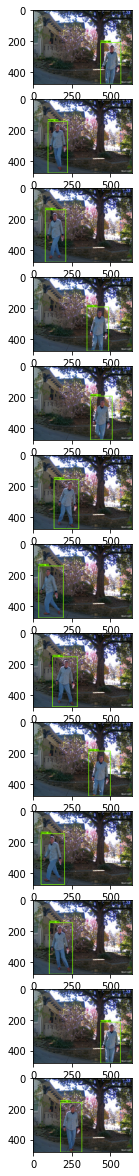

In [9]:


# image_dir = '/home/jay/projects/tensorflow/models/research/object_detection/test_images/'

elapsed = []
for i, image_path in enumerate(image_paths):
    print ("image:", i, image_path)
    image_np = load_image_into_numpy_array(image_path)
    input_tensor = np.expand_dims(image_np, 0)
    start_time = time.time()
    detections = detect_fn(input_tensor)
    end_time = time.time()
    elapsed.append(end_time - start_time)

    # what is a detections?
    # - just once
    if i == 0:
        inf = inference.ModelInference(detections, THRESHOLD)
        print (inf)


        
    plt.rcParams['figure.figsize'] = [42, 21]
    label_id_offset = 1
    image_np_with_detections = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
    plt.subplot(len(image_paths), 1, i+1)
    plt.imshow(image_np_with_detections)
    if i > 20:
        break
        
mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')

## Sending multiple images at once to a model
no, you can't do that - 

  input_signature: (
    TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name='input_tensor'))

In [13]:
elapsed = []
for i, image_path in enumerate(image_paths):
    print ("image:", i, image_path)
    if i == 0:
        image_np = load_image_into_numpy_array(image_path)
        input_tensor = np.expand_dims(image_np, 0)
    else:
        image_np = load_image_into_numpy_array(image_path)
        input_tensor = np.append(input_tensor, np.expand_dims(image_np, 0), axis = 0)

    print ("intermediate shape:", input_tensor.shape)

start_time = time.time()
detections = detect_fn(input_tensor)
end_time = time.time()
elapsed.append(end_time - start_time)

image: 0 /home/train/projects/tf20_vision_samples/cv_images/16076197128-1-0-c.jpg
intermediate shape: (1, 480, 640, 3)
image: 1 /home/train/projects/tf20_vision_samples/cv_images/16076197334-1-0-c.jpg
intermediate shape: (2, 480, 640, 3)
image: 2 /home/train/projects/tf20_vision_samples/cv_images/16076197335-1-0-c.jpg
intermediate shape: (3, 480, 640, 3)
image: 3 /home/train/projects/tf20_vision_samples/cv_images/16076197287-1-0-c.jpg
intermediate shape: (4, 480, 640, 3)
image: 4 /home/train/projects/tf20_vision_samples/cv_images/16076197283-1-0-c.jpg
intermediate shape: (5, 480, 640, 3)
image: 5 /home/train/projects/tf20_vision_samples/cv_images/16076197326-1-0-c.jpg
intermediate shape: (6, 480, 640, 3)
image: 6 /home/train/projects/tf20_vision_samples/cv_images/16076197339-1-0-c.jpg
intermediate shape: (7, 480, 640, 3)
image: 7 /home/train/projects/tf20_vision_samples/cv_images/16076197328-1-0-c.jpg
intermediate shape: (8, 480, 640, 3)
image: 8 /home/train/projects/tf20_vision_sample

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    [[[[ 15  29  56]
   [ 14  31  51]
   [ 18  34  50]
   ...
   [ 43  44  62]
   [ 58  72  81]
   [ 18  47  45]]

  [[ 16  26  51]
   [ 16  31  52]
   [ 29  42  59]
   ...
   [107 114 132]
   [ 14  26  38]
   [ 28  49  54]]

  [[ 52  59  77]
   [ 19  27  48]
   [ 20  32  48]
   ...
   [103 106 123]
   [ 57  64  74]
   [ 33  44  50]]

  ...

  [[ 44  64  75]
   [ 44  64  75]
   [ 42  62  73]
   ...
   [ 19  65   1]
   [ 18  67   2]
   [ 17  67   4]]

  [[ 42  62  73]
   [ 44  64  75]
   [ 43  63  74]
   ...
   [ 24  66   2]
   [ 20  66   1]
   [ 17  66   1]]

  [[ 42  62  71]
   [ 43  63  72]
   [ 40  60  69]
   ...
   [ 26  65   2]
   [ 23  65   2]
   [ 18  64   0]]]


 [[[ 18  23  53]
   [ 16  20  47]
   [ 24  27  46]
   ...
   [ 53  38  67]
   [ 54  52  66]
   [ 28  42  43]]

  [[ 16  23  49]
   [ 24  30  56]
   [ 31  36  58]
   ...
   [108 107 125]
   [ 20  22  34]
   [ 39  46  56]]

  [[ 48  60  76]
   [ 17  25  48]
   [ 20  28  51]
   ...
   [ 94 105 109]
   [ 57  62  68]
   [ 36  36  48]]

  ...

  [[ 43  63  72]
   [ 43  63  74]
   [ 41  61  72]
   ...
   [ 20  65   0]
   [ 23  65   1]
   [ 24  65   5]]

  [[ 43  63  72]
   [ 43  63  72]
   [ 41  61  72]
   ...
   [ 24  65   0]
   [ 25  64   0]
   [ 25  64   1]]

  [[ 42  62  71]
   [ 43  63  72]
   [ 42  62  73]
   ...
   [ 26  66   0]
   [ 27  64   0]
   [ 25  61   0]]]


 [[[ 12  21  50]
   [ 19  26  45]
   [ 26  28  40]
   ...
   [ 48  40  55]
   [ 58  56  69]
   [ 28  36  49]]

  [[ 17  29  45]
   [ 22  29  45]
   [ 28  32  43]
   ...
   [101 108 114]
   [ 18  25  35]
   [ 40  47  65]]

  [[ 47  62  65]
   [ 13  25  37]
   [ 23  29  43]
   ...
   [ 90 107 101]
   [ 52  66  69]
   [ 27  34  52]]

  ...

  [[ 43  63  74]
   [ 43  63  74]
   [ 41  61  72]
   ...
   [ 25  65   5]
   [ 26  64   3]
   [ 27  66   3]]

  [[ 43  63  72]
   [ 43  63  72]
   [ 41  61  70]
   ...
   [ 29  62   5]
   [ 32  63   6]
   [ 32  63   6]]

  [[ 42  62  69]
   [ 43  63  70]
   [ 41  61  68]
   ...
   [ 32  61   7]
   [ 34  61  10]
   [ 34  61  10]]]


 ...


 [[[ 17  22  52]
   [ 17  21  48]
   [ 25  28  47]
   ...
   [ 43  39  53]
   [ 58  54  71]
   [ 35  34  52]]

  [[ 16  23  49]
   [ 20  26  52]
   [ 27  32  54]
   ...
   [100 106 120]
   [ 21  25  37]
   [ 41  43  58]]

  [[ 49  61  77]
   [ 17  25  48]
   [ 20  28  51]
   ...
   [ 95 103 116]
   [ 58  65  71]
   [ 30  37  43]]

  ...

  [[ 43  61  73]
   [ 44  62  74]
   [ 42  60  74]
   ...
   [ 21  65   6]
   [ 20  65  10]
   [ 20  64  13]]

  [[ 42  60  72]
   [ 43  61  73]
   [ 42  60  72]
   ...
   [ 23  63   1]
   [ 22  63   3]
   [ 23  64   6]]

  [[ 43  60  70]
   [ 43  61  71]
   [ 42  60  72]
   ...
   [ 24  63   0]
   [ 26  65   0]
   [ 26  67   1]]]


 [[[ 17  28  60]
   [ 14  30  53]
   [ 16  35  49]
   ...
   [ 41  49  62]
   [ 57  74  82]
   [ 17  43  40]]

  [[ 19  26  52]
   [ 15  30  51]
   [ 27  43  59]
   ...
   [ 96 108 122]
   [ 20  33  42]
   [ 33  46  54]]

  [[ 50  58  71]
   [ 19  30  48]
   [ 20  31  49]
   ...
   [106 113 129]
   [ 56  60  71]
   [ 37  40  49]]

  ...

  [[ 40  62  73]
   [ 43  65  76]
   [ 39  61  72]
   ...
   [ 20  65   8]
   [ 18  66   8]
   [ 15  63   5]]

  [[ 42  62  71]
   [ 45  65  74]
   [ 41  61  70]
   ...
   [ 22  66   5]
   [ 21  65   4]
   [ 20  64   3]]

  [[ 41  61  70]
   [ 44  64  73]
   [ 42  62  71]
   ...
   [ 25  65   3]
   [ 23  65   2]
   [ 24  66   3]]]


 [[[ 14  23  54]
   [ 13  25  49]
   [ 18  29  47]
   ...
   [ 45  42  51]
   [ 51  56  62]
   [ 25  43  47]]

  [[ 15  25  52]
   [ 15  27  51]
   [ 26  39  55]
   ...
   [103 107 110]
   [ 21  30  37]
   [ 29  40  58]]

  [[ 49  57  80]
   [ 17  29  51]
   [ 18  32  45]
   ...
   [ 96 109 102]
   [ 50  63  69]
   [ 29  37  60]]

  ...

  [[ 44  64  73]
   [ 44  64  73]
   [ 41  61  70]
   ...
   [ 20  64   3]
   [ 19  66  11]
   [ 18  66  16]]

  [[ 46  64  74]
   [ 46  64  74]
   [ 42  62  71]
   ...
   [ 23  63   3]
   [ 21  64  11]
   [ 19  62  16]]

  [[ 44  63  70]
   [ 46  65  72]
   [ 45  63  73]
   ...
   [ 25  63   4]
   [ 23  63  10]
   [ 20  62  14]]]])
  input_signature: (
    TensorSpec(shape=(1, None, None, 3), dtype=tf.uint8, name='input_tensor'))